# Capacitance Model

After solving the Thomas-Fermi equations for n(x), QDFlow builds a capacitance
model to determine the dot occupancies.

In [1]:
from qdflow.physics import simulation
from qdflow import generate
import tutorial_helper
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define a set of default physical and numerical parameters
phys = generate.default_physics(n_dots=2)
phys.gates[3].peak = 7.5
x = phys.x
q = phys.q
numerics = simulation.NumericsParameters()

# Calculate V(x) and solve for n(x)
# This may take a few seconds initially due to numba compilation time
V = simulation.calc_V(phys.gates, x, 0, 0)
K_mat = simulation.calc_K_mat(x, phys.K_0, phys.sigma)
delta_x = x[1] - x[0]
g0_dx_K_plus_1_inv = np.linalg.inv(phys.g_0 * delta_x * K_mat + np.identity(len(x)))
n, phi, converged = simulation.ThomasFermi.calc_n(phys, numerics, V, K_mat, g0_dx_K_plus_1_inv)

The first step is identifying the regions in which charges are confined. This is
done by identifying charge "islands" for which n(x) is above some relative value.

This is the step that is responsible for determining whether the dots should be
handled individually, or as a single, combined center dot.

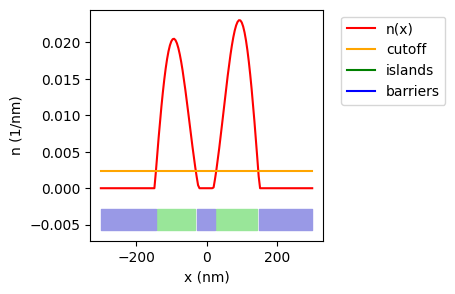

In [3]:
# A relative cutoff value is defined in the NumericsParameters dataclass
cutoff_value = numerics.island_relative_cutoff * np.max(n)

# Calculate the regions correcponding to islands and barriers
islands, barriers, all_islands, is_short_circuit = \
        simulation.ThomasFermi.calc_islands_and_barriers(phys, numerics, n)

# Plot the results
fig, ax = plt.subplots(figsize=(3,3))
tutorial_helper.plot_n(fig, ax, x, n)
tutorial_helper.plot_islands_and_barriers(fig, ax, x, n, islands, barriers, cutoff_value)
ax.legend(["n(x)","cutoff","islands","barriers"], bbox_to_anchor=(1.05, 1), loc='upper left');

Next, approximate charge occupancies $Z_i$ are calculated by integrating n(x) over
each charge island. Note that this will give a real number, not an integer
number of charges.

In [4]:
approx_charges = simulation.ThomasFermi.calc_approximate_charges(phys, n, islands)
print(approx_charges)

[1.53816277 1.80652947]


Now we build a capacitance model based off the result of n(x).

Specifically, we are interested in the energy matrix $E_{ij}$, which gives the
energy of an integer charge configuration $\vec{Q}$:

$E=\sum_{i,j}E_{ij}(Q_i-Z_i)(Q_j-Z_j)$

The energy matrix is found by calculating the average Coulomb potential energy
between dots i and j. Then an additional term is added along the diagonal to
account for the kinetic energy of charges in each dot. The strength of this
second term can be adjusted by changing `PhysicsParameters.c_k`.

In [5]:
# Calculate the energy matrix
energy_matrix = simulation.ThomasFermi.calc_energy_matrix(phys, numerics,
                K_mat, n, islands, approx_charges)
print("Energy matrix:\n", energy_matrix, "\n")

# Calculate and print out the energies of several charge configurations
configurations_to_check = np.array([[1,1], [1,2], [2,1], [2,2]], dtype=np.int_)
for config in configurations_to_check:
    energy = simulation.ThomasFermi.calc_cap_energy(config, energy_matrix, approx_charges)
    print("Energy of charge state", config, ": %0.5f" % energy)

Energy matrix:
 [[0.04923472 0.01370183]
 [0.01370183 0.04829884]] 

Energy of charge state [1 1] : 0.05757
Energy of charge state [1 2] : 0.01321
Energy of charge state [2 1] : 0.03171
Energy of charge state [2 2] : 0.01476


QDFlow uses a brute-force search of all integer charge configurations close to
`approx_charges` to determine which charge configuration has the lowest energy.

In [6]:
# Calculate the lowest-energy state
island_charges = simulation.ThomasFermi.calc_island_charges(numerics,
                 energy_matrix, approx_charges)
print("Lowest-energy state:", island_charges)

Lowest-energy state: [1 2]


This charge state vector has length equal to the number of charge islands.
However, the number of charge islands varies depending on n(x). For example:
* A double-dot has 2 islands, as seen above.
* There could be 1 island if the voltage of one of the plunger gates is reduced.
* There could be no islands if both plunger gates are reduced.
* If the barrier is reduced, there is only 1 central, combined charge island.
* There might be some other arrangment of islands for extreme / unconventional
choices of parameters or layouts with more than 2 dots.

When reporting data in a CSD, it is nice to standarize the length of the charge
state vector, so that the charge states for all points can be stored together 
in a single numpy `ndarray`.

Our solution is to set the length equal to the number of plunger gates (assuming
one plunger gate per dot). Then the charge islands are matched up to the closest
corresponding plunger. In the case of combined dots, all charges are placed in
the left-most entry, and a seperate variable is used to record that the dots are
combined together.

For example, a single island with 3 dots will have `island_charges == [3]`.
This can be expanded to length 2 in different ways, depending on where the
island is located:
* If the island is above the left plunger, it will become `[3, 0]`
* If the island is above the right plunger, it will become `[0, 3]`
* If the island is a single large, combined dot, it will become `[3, 0]`, and
`are_dots_combined` will be set to True to distinguish from the first case.

In [7]:
# Calculate the charge state
charge_centers = simulation.ThomasFermi.calc_charge_centers(phys, n, islands)
are_dots_occupied, are_dots_combined, dot_charges = \
        simulation.ThomasFermi.calc_dot_states(phys, islands, island_charges, charge_centers)
print("Charge state:", dot_charges)
print("are_dots_combined:", are_dots_combined)

Charge state: [1 2]
are_dots_combined: [False]


Finally, the sensor readout is calculated by calculating the screened potential
due to each of the charges at one or more sensor locations.

In [8]:
# Calculate sensor output
sensor_output = simulation.ThomasFermi.sensor_from_charge_state(phys, n,
        islands, dot_charges, are_dots_combined)
print("Single sensor output:", sensor_output)

# Calculate output for multiple sensors at a time
# Sensors should be provided as a numpy array with shape (num_sensors, 3)
# giving the (x, y, z) coordinates of each sensor
phys_multiple_sensors = phys.copy()
phys_multiple_sensors.sensors = np.array([[-200, 100, 0], [200, 100, 0]])
multi_sensor_output = simulation.ThomasFermi.sensor_from_charge_state(
        phys_multiple_sensors, n, islands, dot_charges, are_dots_combined)
print("Multiple sensor output:", multi_sensor_output)

Single sensor output: [-2.39504244]
Multiple sensor output: [-0.51501873 -0.90571996]
